In [10]:
with open('data/headlines.txt') as infile:
    lines = infile.readlines()
lines[-5:]

['Rumors about Rabies spreading in Jerusalem have been refuted\n',
 'More Zika patients reported in Indang\n',
 'Suva authorities confirmed the spread of Rotavirus\n',
 'More Zika patients reported in Bella Vista\n',
 'Zika Outbreak in Wichita Falls\n']

In [11]:
#apply unidecode
from unidecode import unidecode
lines = [unidecode(line.strip()) for line in lines]
lines[-5:]

['Rumors about Rabies spreading in Jerusalem have been refuted',
 'More Zika patients reported in Indang',
 'Suva authorities confirmed the spread of Rotavirus',
 'More Zika patients reported in Bella Vista',
 'Zika Outbreak in Wichita Falls']

In [12]:
import geonamescache

gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
cities = gc.get_cities()

In [13]:
countries_list = []
for country_value in list(countries.values()):
    countries_list.append(country_value['name'])
countries_list[:10]

['Andorra',
 'United Arab Emirates',
 'Afghanistan',
 'Antigua and Barbuda',
 'Anguilla',
 'Albania',
 'Armenia',
 'Angola',
 'Antarctica',
 'Argentina']

In [14]:
cities_list = []
for city_value in list(cities.values()):
    cities_list.append(city_value['name'])
cities_list.append('Sao Paulo')
cities_list[:10]

['Andorra la Vella',
 'Umm Al Quwain City',
 'Ras Al Khaimah City',
 'Zayed City',
 'Khawr Fakkān',
 'Dubai',
 'Dibba Al-Fujairah',
 'Dibba Al-Hisn',
 'Sharjah',
 'Ar Ruways']

In [15]:
import numpy as np
import re
cities_data = []
countries_data = []
for line in lines:
    temp_country = []
    temp_city = []
    for country in set(countries_list):
        if country in line:
            temp_country.append(country)
    for city in set(cities_list):
        if city in line:
            pattern = city + "[a-z]+"
            if re.search(pattern, line) is None:
                temp_city.append(city)
    if not temp_city:
        temp_city.append(np.nan)
    else:
        temp_city_copy = temp_city.copy()
        no_city = []
        for i in range(len(temp_city_copy) - 1):
            for j in range(i + 1, len(temp_city_copy)):
                if temp_city[i] in temp_city[j]:
                    no_city.append(temp_city[i])
                elif temp_city[j] in temp_city[i]:
                    no_city.append(temp_city[j])
        for aCity in no_city:
            if aCity in temp_city:
                temp_city.remove(aCity)
    if not temp_country:
        temp_country.append(np.nan)
    cities_data.append(temp_city)
    countries_data.append(temp_country)
            


In [17]:
import pandas as pd
df = pd.DataFrame()
df["Headlines"] = lines
df["Cities"] = cities_data
df["Countries"] = countries_data
df.head()

,Headlines,Cities,Countries
0,Zika Outbreak Hits Miami,[Miami],[nan]
1,Could Zika Reach New York City?,[New York City],[nan]
2,First Case of Zika in Miami Beach,[Miami Beach],[nan]
3,"Mystery Virus Spreads in Recife, Brazil",[Recife],[Brazil]
4,Dallas man comes down with case of Zika,[Dallas],[nan]


In [18]:
def parse(x):
    if type(x[0]) == 'float':
        return None
    return x[0]

df["Cities"] = df["Cities"].map(parse)
df["Countries"] = df["Countries"].map(parse)
df.head()

,Headlines,Cities,Countries
0,Zika Outbreak Hits Miami,Miami,NaN
1,Could Zika Reach New York City?,New York City,NaN
2,First Case of Zika in Miami Beach,Miami Beach,NaN
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
4,Dallas man comes down with case of Zika,Dallas,NaN


In [ ]:
df.head()

In [ ]:
df.info()

In [19]:
#remove countries
df.drop('Countries', axis = 1, inplace = True)
df.head()

,Headlines,Cities
0,Zika Outbreak Hits Miami,Miami
1,Could Zika Reach New York City?,New York City
2,First Case of Zika in Miami Beach,Miami Beach
3,"Mystery Virus Spreads in Recife, Brazil",Recife
4,Dallas man comes down with case of Zika,Dallas


In [20]:
#let us drop missing cities
df.dropna(inplace = True)
df.isnull().any()

Headlines    False
Cities       False
dtype: bool

In [ ]:
df.shape

In [21]:
cities = list(df['Cities'])
latitudes = []
longitudes = []
for city in cities:
    x = gc.get_cities_by_name(city)
    if x:
        lat = list(x[0].values())[0]['latitude']
        long = list(x[0].values())[0]['longitude']
        latitudes.append(lat)
        longitudes.append(long)
    else:
        latitudes.append(np.nan)
        longitudes.append(np.nan)
df['latitude'] = latitudes
df['longitude'] = longitudes
df.head()

,Headlines,Cities,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667


In [22]:
df.dropna(inplace = True)

In [23]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

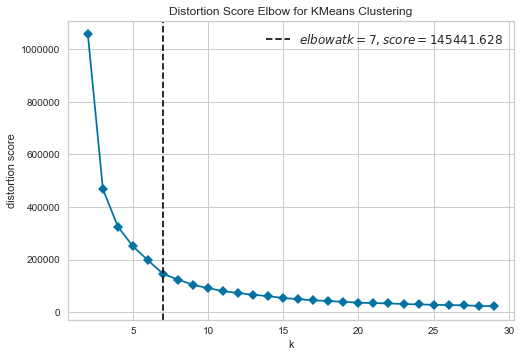

In [24]:
data = df[['latitude', 'longitude']]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings = False)
visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show() 


In [25]:
#We will go with the distortion metric and select 7 components
km = KMeans(n_clusters=7, random_state=999)
km.fit(data) #computes k-means clustering
cluster_membership = list(km.predict(data)) #predicts closest cluster
df["KM_Cluster"] = cluster_membership
df.head()

,Headlines,Cities,latitude,longitude,KM_Cluster
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,3
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,0


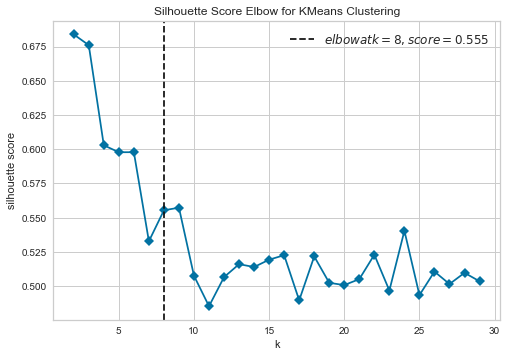

In [26]:
#let us try the silhouette method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), metric = 'silhouette',
                              timings = False)
visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show() 

In [28]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stopwords = list(ENGLISH_STOP_WORDS)
def preprocess_text(aText):
    aText = aText.lower()
    #remove punctuation and digits, if any
    p = string.punctuation
    pattern = '[^\d' + p + ']*'
    aText = "".join(re.findall(pattern , aText))
    #remove stopwords
    aText = " ".join([word for word in aText.split() if word not in stopwords])
    return aText
    

In [29]:
#test preprocess_text
preprocess_text("Wow! 2020 has been a terrible year, right? So was 1930.")

'wow terrible year right'

In [34]:
#let us try to get the top 5 words associated with each cluster
#to enable us to label them
from collections import Counter
for i in range(7):
    sub_df = df[df['KM_Cluster'] == i]
    text = " ".join(list(sub_df['Headlines']))
    text = preprocess_text(text)
    words = text.split()
    counts = Counter(words)
    top_five_words = list(dict(counts.most_common(5)).keys())
    print("Cluster " + str(i) + ": " + str(top_five_words))
    all_cities = list(sub_df['Cities'])
    city_counts = Counter(all_cities)
    top_five_cities = list(dict(city_counts.most_common(5)).keys())
    print("Top Cities for " + str(i) + ": " + str(top_five_cities))
    print("*" * 30)

Cluster 0: ['zika', 'outbreak', 'spread', 'virus', 'vaccine']
Top Cities for 0: ['Miami', 'Monroe', 'London', 'Hollywood', 'Panama City']
******************************
Cluster 1: ['zika', 'virus', 'reported', 'city', 'outbreak']
Top Cities for 1: ['San Jose', 'Manila', 'Iloilo', 'Ho Chi Minh City', 'Bangkok']
******************************
Cluster 2: ['mad', 'cow', 'disease', 'outbreak', 'vaccine']
Top Cities for 2: ['Barcelona', 'Rochester', 'Birmingham', 'Bedford', 'Lisbon']
******************************
Cluster 3: ['zika', 'outbreak', 'symptoms', 'case', 'san']
Top Cities for 3: ['Madrid', 'Florida', 'Colombo', 'Recife', 'Trinidad']
******************************
Cluster 4: ['zika', 'vaccine', 'virus', 'spreading', 'new']
Top Cities for 4: ['Los Angeles', 'Vancouver', 'Seattle', 'Fort Collins', 'El Paso']
******************************
Cluster 5: ['spread', 'malaria', 'hepatitis', 'spreading', 'authorities']
Top Cities for 5: ['Johannesburg', 'Ibadan', 'Greenville', 'Zanzibar', 'E

In [78]:
epsilon = 15
min_points = 1
from sklearn.cluster import DBSCAN
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
clusters = cluster_model.fit_predict(data)
#colors = [['g', 'y', 'k'][cluster] for cluster in rock_clusters]
#plt.scatter(x_coordinates, y_coordinates, color=colors)
#plt.show()
set(clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [81]:
df["DBScan_clusters"] = clusters

In [84]:
df["DBScan_clusters"].value_counts()

0     378
2      89
1      79
3      18
4      12
8       3
7       2
10      1
9       1
6       1
5       1
Name: DBScan_clusters, dtype: int64

In [83]:
for i in range(11):
    sub_df = df[df['DBScan_clusters'] == i]
    text = " ".join(list(sub_df['Headlines']))
    text = preprocess_text(text)
    words = text.split()
    counts = Counter(words)
    top_five_words = list(dict(counts.most_common(5)).keys())
    print("Cluster " + str(i) + ": " + str(top_five_words))
    all_cities = list(sub_df['Cities'])
    city_counts = Counter(all_cities)
    top_five_cities = list(dict(city_counts.most_common(5)).keys())
    print("Top Cities for " + str(i) + ": " + str(top_five_cities))
    print("*" * 30)

Cluster 0: ['zika', 'outbreak', 'spread', 'virus', 'vaccine']
Top Cities for 0: ['Miami', 'Madrid', 'Monroe', 'London', 'Florida']
******************************
Cluster 1: ['zika', 'virus', 'reported', 'city', 'outbreak']
Top Cities for 1: ['San Jose', 'Manila', 'Iloilo', 'Ho Chi Minh City', 'Bangkok']
******************************
Cluster 2: ['mad', 'cow', 'vaccine', 'disease', 'spread']
Top Cities for 2: ['Barcelona', 'Rochester', 'Johannesburg', 'Birmingham', 'Bedford']
******************************
Cluster 3: ['zika', 'patients', 'virus', 'reported', 'melbourne']
Top Cities for 3: ['Melbourne', 'Orange', 'Richmond', 'Fairfield', 'Townsville']
******************************
Cluster 4: ['spread', 'tuberculosis', 'hepatitis', 'left', 'ibadan']
Top Cities for 4: ['Ibadan', 'Greenville', 'Dakar', 'Abuja', 'Libreville']
******************************
Cluster 5: ['zika', 'virus', 'majuro']
Top Cities for 5: ['Majuro']
******************************
Cluster 6: ['lower', 'hospitalization

In [85]:
from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()

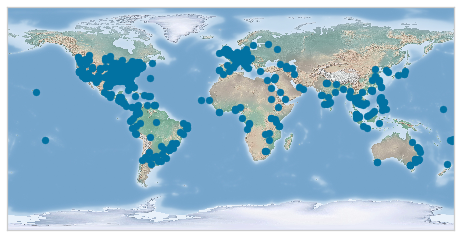

In [88]:
import matplotlib.pyplot as plt
latitudes = list(df['latitude'])
longitudes = list(df['longitude'])
map_plotter.scatter(longitudes, latitudes, latlon=True)
map_plotter.shadedrelief()
plt.show()